In [1]:
import pandas as pd
import numpy as np

## Importing previously imputed data

In [2]:
zillow_data = pd.read_csv('../../data/zillow_full_imputed.csv',dtype={'Zipcode':str})

In [3]:
zillow_data.set_index('Date',inplace = True)

In [4]:
zillow_data.shape

(17751, 29)

In [5]:
zillow_data.columns

Index(['Zipcode', 'City', 'State', 'Metro', 'County', 'SizeRank', 'Rent',
       'Year', 'State-County', 'AQIMean', 'PersonalIncome',
       'Vol_moderate_income', 'Vol_low_income', 'total_pop', 'households',
       'median_age', 'median_income', 'income_per_capita', 'gini_index',
       'pct_poverty', 'housing_availability', 'home_density', 'pct_employed',
       'pct_jobs_nightlife', 'pct_unemployed', 'move_within_city',
       'move_new_city', 'avg_commute_time', 'pct_college'],
      dtype='object')

In [6]:
zillow_data.isnull().sum()

Zipcode                 0
City                    0
State                   0
Metro                   0
County                  0
SizeRank                0
Rent                    0
Year                    0
State-County            0
AQIMean                 0
PersonalIncome          0
Vol_moderate_income     0
Vol_low_income          0
total_pop               0
households              0
median_age              0
median_income           0
income_per_capita       0
gini_index              0
pct_poverty             0
housing_availability    0
home_density            0
pct_employed            0
pct_jobs_nightlife      0
pct_unemployed          0
move_within_city        0
move_new_city           0
avg_commute_time        0
pct_college             0
dtype: int64

## Random Forest regressor

In [7]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [38]:
LE = LabelEncoder()
ss = StandardScaler()
features = zillow_data.drop(['Rent','State-County','State','Year','City','Metro','County',
                            'AQIMean','Vol_moderate_income','Vol_low_income'],axis = 1)
y = np.log(zillow_data['Rent'])

In [9]:

# features['Zipcode'] = features['Zipcode'].astype(int)

In [39]:
cat_cols = features.select_dtypes(include = object).copy()
num_cols = features.select_dtypes(exclude = object).copy()

In [40]:
for col in cat_cols.columns:
    cat_cols[col] = LE.fit_transform(cat_cols[col])

X = pd.concat([cat_cols,num_cols],axis = 1)

In [41]:
X.shape

(17751, 19)

In [42]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_estimators = 500)

In [14]:
print(X.index[0])
print(X.index[-1])

2015-01-01
2020-01-01


In [50]:
X.columns

Index(['Zipcode', 'SizeRank', 'PersonalIncome', 'total_pop', 'households',
       'median_age', 'median_income', 'income_per_capita', 'gini_index',
       'pct_poverty', 'housing_availability', 'home_density', 'pct_employed',
       'pct_jobs_nightlife', 'pct_unemployed', 'move_within_city',
       'move_new_city', 'avg_commute_time', 'pct_college'],
      dtype='object')

In [44]:
#splitting train/test sets before/after 2019
Xtrain = X.loc[X.index <'2019-01-01']
train_index = Xtrain.shape[0]
Xtest = X[train_index:]
ytrain = y[:train_index]
ytest = y[train_index:]


In [45]:
rfc.fit(Xtrain,ytrain)

RandomForestRegressor(n_estimators=500)

In [46]:
rfc.score(Xtrain,ytrain)

0.9943089043555141

In [47]:
rfc.score(Xtest,ytest)

0.9693600234908926

In [48]:
rfc.feature_importances_

array([0.37951025, 0.00152455, 0.19201031, 0.00642119, 0.00133476,
       0.00513802, 0.18884436, 0.0467633 , 0.02311647, 0.00726344,
       0.03127187, 0.00422901, 0.00271832, 0.00736801, 0.00226957,
       0.02178914, 0.00887198, 0.04751957, 0.0220359 ])

In [51]:
rfc_imp = pd.DataFrame({'Columns':X.columns,'Feature_importances':rfc.feature_importances_})

In [52]:
rfc_imp.sort_values(by = 'Feature_importances',ascending = False)

,Columns,Feature_importances
0,Zipcode,0.379510
2,PersonalIncome,0.192010
6,median_income,0.188844
17,avg_commute_time,0.047520
7,income_per_capita,0.046763
10,housing_availability,0.031272
8,gini_index,0.023116
18,pct_college,0.022036
15,move_within_city,0.021789
16,move_new_city,0.008872


In [53]:
ypred = rfc.predict(Xtest)

In [54]:
from sklearn.metrics import mean_squared_error

In [55]:
RMSE = mean_squared_error(ytest,ypred, squared = False)
print(f'RMSE: {RMSE}')

RMSE: 0.049612897746764056


In [56]:
from sklearn.model_selection import GridSearchCV
estimators= list(map(int,np.linspace(400,700,4)))
param_grid = {'n_estimators':estimators}

estimators

[400, 500, 600, 700]

In [57]:
grid = GridSearchCV(RandomForestRegressor(),param_grid = param_grid)

In [58]:
grid.fit(Xtrain,ytrain)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [400, 500, 600, 700]})

In [60]:
grid.best_params_

{'n_estimators': 600}

In [61]:
grid.score(Xtest,ytest)

0.9700021182484282

In [62]:
grid.best_score_

0.9834474001322502

In [63]:
y_pred = grid.predict(Xtest)
print(mean_squared_error(ytest,ypred,squared = False))

0.049612897746764056


In [64]:
rfc.set_params(**grid.best_params_)

RandomForestRegressor(n_estimators=600)

In [65]:
rfc.fit(Xtrain,ytrain)

RandomForestRegressor(n_estimators=600)

In [66]:
rfc.score(Xtest,ytest)

0.9695240175484278

In [67]:
rfc_imp = pd.DataFrame({'Columns':X.columns,'Feature_importances':rfc.feature_importances_})

rfc_imp.sort_values(by = 'Feature_importances',ascending = False)

,Columns,Feature_importances
0,Zipcode,0.365642
2,PersonalIncome,0.194866
6,median_income,0.186544
7,income_per_capita,0.055079
17,avg_commute_time,0.052681
10,housing_availability,0.031435
8,gini_index,0.023380
15,move_within_city,0.022088
18,pct_college,0.020486
16,move_new_city,0.008851


## Writing CV to preserve time-series structure

In [39]:
import seaborn as sns

<AxesSubplot:>

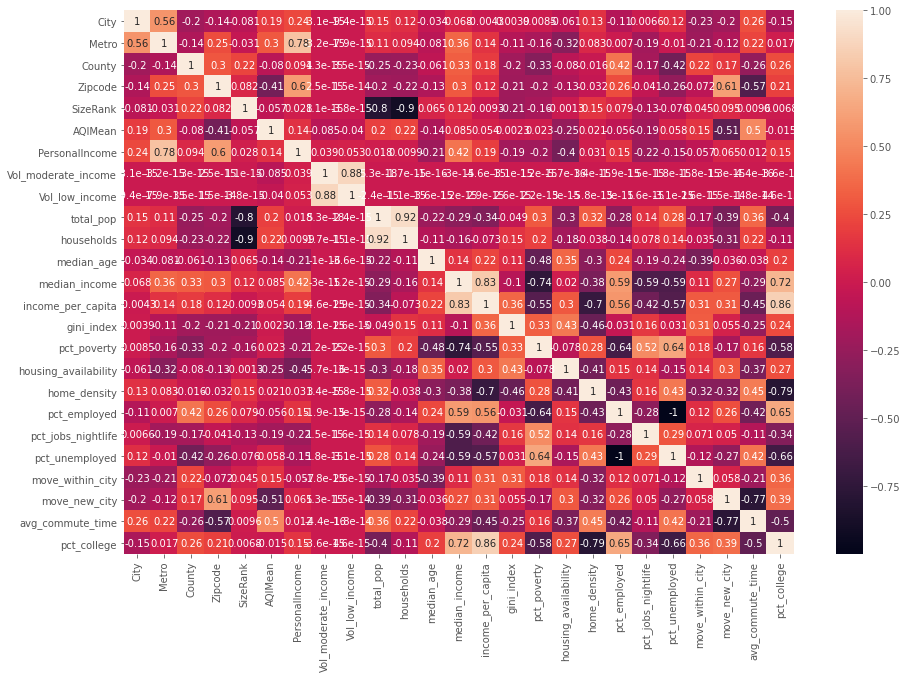

In [41]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize = (15,10))
sns.heatmap(X.corr(),annot = True)


In [74]:
rent_dates = X.index.unique()

train_end = 9
test_start = train_end
test_end = test_start +3

cv_dict = {'train_score':[],
              'test_score':[],
              'RMSE':[]}

predictions = []
rfc_cv = RandomForestRegressor()
rfc_cv.set_params(n_estimators = 600)

while test_end <=len(rent_dates):


    Xtrain = X[X.index.isin(rent_dates[:train_end])]
    ytrain = y[y.index.isin(rent_dates[:train_end])]
    Xtest = X[X.index.isin(rent_dates[test_start:test_end])]
    ytest = y[y.index.isin(rent_dates[test_start:test_end])]
    rfc_cv.fit(Xtrain,ytrain)
    cv_dict['train_score'].append(rfc_cv.score(Xtrain,ytrain))
    cv_dict['test_score'].append(rfc_cv.score(Xtest,ytest))
    cv_pred = rfc_cv.predict(Xtest)
    predictions.extend(cv_pred)
    cv_dict['RMSE'].append(mean_squared_error(ytest,cv_pred,squared = False))
    
    print(f'Training date range: {Xtrain.index.unique().tolist()[0]} : {Xtrain.index.unique().tolist()[-1]}')
    print(f'Testing date range: {Xtest.index.unique().tolist()[0]} : {Xtest.index.unique().tolist()[-1]}')
    print(f'Random forest test score: {rfc_cv.score(Xtest,ytest)}\n')
    train_end +=3
    test_start +=3
    test_end +=3

Training date range: 2015-01-01 : 2015-09-01
Testing date range: 2015-10-01 : 2015-12-01
Random forest test score: 0.9674819106102589

Training date range: 2015-01-01 : 2015-12-01
Testing date range: 2016-01-01 : 2016-03-01
Random forest test score: 0.9672526879213266

Training date range: 2015-01-01 : 2016-03-01
Testing date range: 2016-04-01 : 2016-06-01
Random forest test score: 0.9929888456669386

Training date range: 2015-01-01 : 2016-06-01
Testing date range: 2016-07-01 : 2016-09-01
Random forest test score: 0.9910714664545834

Training date range: 2015-01-01 : 2016-09-01
Testing date range: 2016-10-01 : 2016-12-01
Random forest test score: 0.9878670883773013

Training date range: 2015-01-01 : 2016-12-01
Testing date range: 2017-01-01 : 2017-03-01
Random forest test score: 0.5258196441580445

Training date range: 2015-01-01 : 2017-03-01
Testing date range: 2017-04-01 : 2017-06-01
Random forest test score: 0.9962638573267042

Training date range: 2015-01-01 : 2017-06-01
Testing da

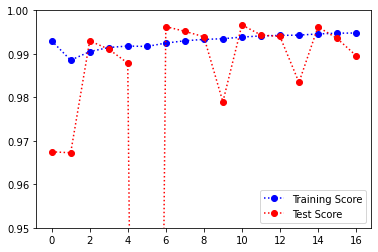

In [77]:
import matplotlib.pyplot as plt
cv_results = pd.DataFrame(cv_dict)
plt.plot(cv_results['train_score'],'bo:')
plt.plot(cv_results['test_score'],'ro:')
plt.legend(['Training Score','Test Score'])
plt.ylim([.95,1])
plt.show()


In [78]:
print(cv_results['test_score'].mean())
print(cv_results.shape[0])

0.9614466776350235
17


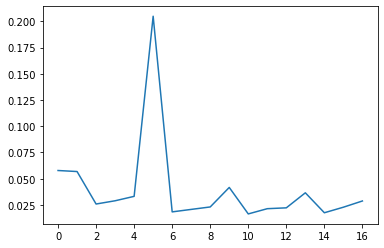

In [79]:
plt.plot(cv_results['RMSE'])

In [82]:
Xtest.shape

(873, 19)

In [84]:
grid.predict()

AttributeError: 'Index' object has no attribute 'year'

In [85]:
test = X.reset_index().copy()

In [94]:
from math import exp
exp(RMSE)

1.0508642257212095

In [96]:
np.mean(np.exp(cv_results['RMSE']))

1.0416351630391514